<a href="https://colab.research.google.com/github/SebastienLiger/Portfolio-Finance/blob/Finance/Trading_Equity_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#import libraries
import pandas_datareader as pdr
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

In [24]:
#define date range
START = datetime.datetime(2022, 1, 3)
END = datetime.datetime.today()
YEARS = (END - START).days/ 365.25

In [25]:
#define starting variables
STARTING_BALANCE = 1000000
PCT_THRESH = 20

In [26]:
#download data
price = yf.download('^GSPC', START, END)

price.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,4778.140137,4796.640137,4758.169922,4796.560059,4796.560059,3831020000
2022-01-04,4804.509766,4818.620117,4774.270020,4793.540039,4793.540039,4683170000
2022-01-05,4787.990234,4797.700195,4699.439941,4700.580078,4700.580078,4887960000
2022-01-06,4693.390137,4725.009766,4671.259766,4696.049805,4696.049805,4295280000
2022-01-07,4697.660156,4707.950195,4662.740234,4677.029785,4677.029785,4181510000


In [27]:
#drop redundant columns
price = price.drop(['Volume', 'Adj Close'], 1)

price.tail()

<ipython-input-27-c564450f4bc6>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)


,Open,High,Low,Close
Date,,,,
2024-03-12,5134.299805,5179.870117,5114.479980,5175.270020
2024-03-13,5173.490234,5179.140137,5151.879883,5165.310059
2024-03-14,5175.140137,5176.850098,5123.299805,5150.479980
2024-03-15,5123.310059,5136.859863,5104.350098,5117.089844
2024-03-18,5154.770020,5175.600098,5154.770020,5163.000000


In [28]:
#calculate benchmark return and balance
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

price.tail()

,Open,High,Low,Close,Return,Bench_Bal
Date,,,,,,
2024-03-12,5134.299805,5179.870117,5114.479980,5175.270020,1.011202,1.078954e+06
2024-03-13,5173.490234,5179.140137,5151.879883,5165.310059,0.998075,1.076878e+06
2024-03-14,5175.140137,5176.850098,5123.299805,5150.479980,0.997129,1.073786e+06
2024-03-15,5123.310059,5136.859863,5104.350098,5117.089844,0.993517,1.066825e+06
2024-03-18,5154.770020,5175.600098,5154.770020,5163.000000,1.008972,1.076396e+06


In [29]:
#calculate benchmark drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

bench_dd

-25.43

In [30]:
#calculate additional columns for strategy

#daily range
price['Range'] = price.High - price.Low
#distance between close and daily low
price['Dist'] = abs(price.Close - price.Low)
#distance as % of range
price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct
Date,,,,,,,,,,,
2024-03-12,5134.299805,5179.870117,5114.479980,5175.270020,1.011202,1.078954e+06,1.078954e+06,0.000000,65.390137,60.790039,92.965151
2024-03-13,5173.490234,5179.140137,5151.879883,5165.310059,0.998075,1.076878e+06,1.078954e+06,-2076.479981,27.260254,13.430176,49.266510
2024-03-14,5175.140137,5176.850098,5123.299805,5150.479980,0.997129,1.073786e+06,1.078954e+06,-5168.295353,53.550293,27.180176,50.756353
2024-03-15,5123.310059,5136.859863,5104.350098,5117.089844,0.993517,1.066825e+06,1.078954e+06,-12129.562660,32.509766,12.739746,39.187444
2024-03-18,5154.770020,5175.600098,5154.770020,5163.000000,1.008972,1.076396e+06,1.078954e+06,-2558.087334,20.830078,8.229980,39.510080


In [31]:
#identify entries and allocate trading fees
price['Long'] = price.Pct < PCT_THRESH

In [32]:
#calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal
Date,,,,,,,,,,,,,,
2024-03-12,5134.299805,5179.870117,5114.479980,5175.270020,1.011202,1.078954e+06,1.078954e+06,0.000000,65.390137,60.790039,92.965151,False,1.0,1.099832e+06
2024-03-13,5173.490234,5179.140137,5151.879883,5165.310059,0.998075,1.076878e+06,1.078954e+06,-2076.479981,27.260254,13.430176,49.266510,False,1.0,1.099832e+06
2024-03-14,5175.140137,5176.850098,5123.299805,5150.479980,0.997129,1.073786e+06,1.078954e+06,-5168.295353,53.550293,27.180176,50.756353,False,1.0,1.099832e+06
2024-03-15,5123.310059,5136.859863,5104.350098,5117.089844,0.993517,1.066825e+06,1.078954e+06,-12129.562660,32.509766,12.739746,39.187444,False,1.0,1.099832e+06
2024-03-18,5154.770020,5175.600098,5154.770020,5163.000000,1.008972,1.076396e+06,1.078954e+06,-2558.087334,20.830078,8.229980,39.510080,False,1.0,1.099832e+06


In [33]:
#calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

sys_dd

-11.25

In [34]:
#calculate metrics
bench_return = round(((price.Bench_Bal[-1]/price.Bench_Bal[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal[-1]/price.Sys_Bal[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100), 2)
sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')

Benchmark Total return: 7.64%
Benchmark CAGR: 3.4
Benchmark DD: -25.43%

System Total return: 9.98%
System CAGR: 4.41
System DD: -11.25%
Time in Market: 23%
Trades Won: 62
Trades Loss: 66
Winrate: 48.44%


In [35]:
# Utiliser les noms de variables déjà définis
print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'My Portfolio Return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')  # Utiliser sys_win à la place de sys_win_count
print(f'Trades Loss: {sys_loss}')  # Utiliser sys_loss à la place de sys_loss_count
print(f'Winrate: {sys_winrate}%')

# Filtrer les trades gagnants et perdants
winning_trades = price[price.Sys_Ret > 1.0]
losing_trades = price[price.Sys_Ret < 1.0]

# Informations sur les trades gagnants
print("\nWinning Trades:")
for i, row in winning_trades.iterrows():
    print(f"Date: {i}, Return: {round((row['Sys_Ret'] - 1) * 100, 2)}%")

# Informations sur les trades perdants
print("\nLosing Trades:")
for i, row in losing_trades.iterrows():
    print(f"Date: {i}, Return: {round((row['Sys_Ret'] - 1) * 100, 2)}%")

Benchmark Total return: 7.64%
Benchmark CAGR: 3.4
Benchmark DD: -25.43%

My Portfolio Return: 9.98%
System CAGR: 4.41
System DD: -11.25%
Time in Market: 23%
Trades Won: 62
Trades Loss: 66
Winrate: 48.44%

Winning Trades:
Date: 2022-01-14 00:00:00, Return: 0.08%
Date: 2022-01-24 00:00:00, Return: 0.28%
Date: 2022-01-28 00:00:00, Return: 2.43%
Date: 2022-02-04 00:00:00, Return: 0.52%
Date: 2022-02-24 00:00:00, Return: 1.5%
Date: 2022-03-09 00:00:00, Return: 2.57%
Date: 2022-03-15 00:00:00, Return: 2.14%
Date: 2022-03-24 00:00:00, Return: 1.43%
Date: 2022-04-01 00:00:00, Return: 0.34%
Date: 2022-04-13 00:00:00, Return: 1.12%
Date: 2022-04-25 00:00:00, Return: 0.57%
Date: 2022-04-27 00:00:00, Return: 0.21%
Date: 2022-05-02 00:00:00, Return: 0.57%
Date: 2022-05-10 00:00:00, Return: 0.25%
Date: 2022-07-19 00:00:00, Return: 2.76%
Date: 2022-08-03 00:00:00, Return: 1.56%
Date: 2022-08-12 00:00:00, Return: 1.73%
Date: 2022-08-24 00:00:00, Return: 0.29%
Date: 2022-09-01 00:00:00, Return: 0.3%
Da

In [36]:
#define list of ETFs to backtest
symbols = ['^GSPC', '^DJI', '^IXIC', '^FCHI', '^GDAXI']

In [37]:
#create backtesting function
def backtest(symbol):
    #download data
    price = yf.download(symbol, START, END)

    #drop redundant columns
    price = price.drop(['Volume', 'Adj Close'], 1)

    #calculate benchmark return and balance
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

    #calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    #calculate additional columns for strategy
    #daily range
    price['Range'] = price.High - price.Low
    #distance between close and daily low
    price['Dist'] = abs(price.Close - price.Low)
    #distance as % of range
    price['Pct'] = (price.Dist / price.Range) * 100

    #identify entries and allocate trading fees
    price['Long'] = price.Pct < PCT_THRESH

    #calculate system return and balance
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())

    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

    #calculate metrics
    bench_cagr = round(((((price.Bench_Bal[-1]/price.Bench_Bal[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal[-1]/price.Sys_Bal[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

    return bench_cagr, sys_cagr

In [38]:
#backtest multiple symbols
bc = []
sc = []


for symbol in symbols:
    bench_cagr, sys_cagr = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)

[*********************100%%**********************]  1 of 1 completed
<ipython-input-37-cd6e69c9a35a>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)
[*********************100%%**********************]  1 of 1 completed
<ipython-input-37-cd6e69c9a35a>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)
[*********************100%%**********************]  1 of 1 completed
<ipython-input-37-cd6e69c9a35a>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  price = price.drop(['Volume', 'Adj Close'], 1)
[*********************100%%**********************]  1 of 1 completed
<ipython-input-37-cd6e69c9a35a>:7: FutureWarning: In a future version of pan

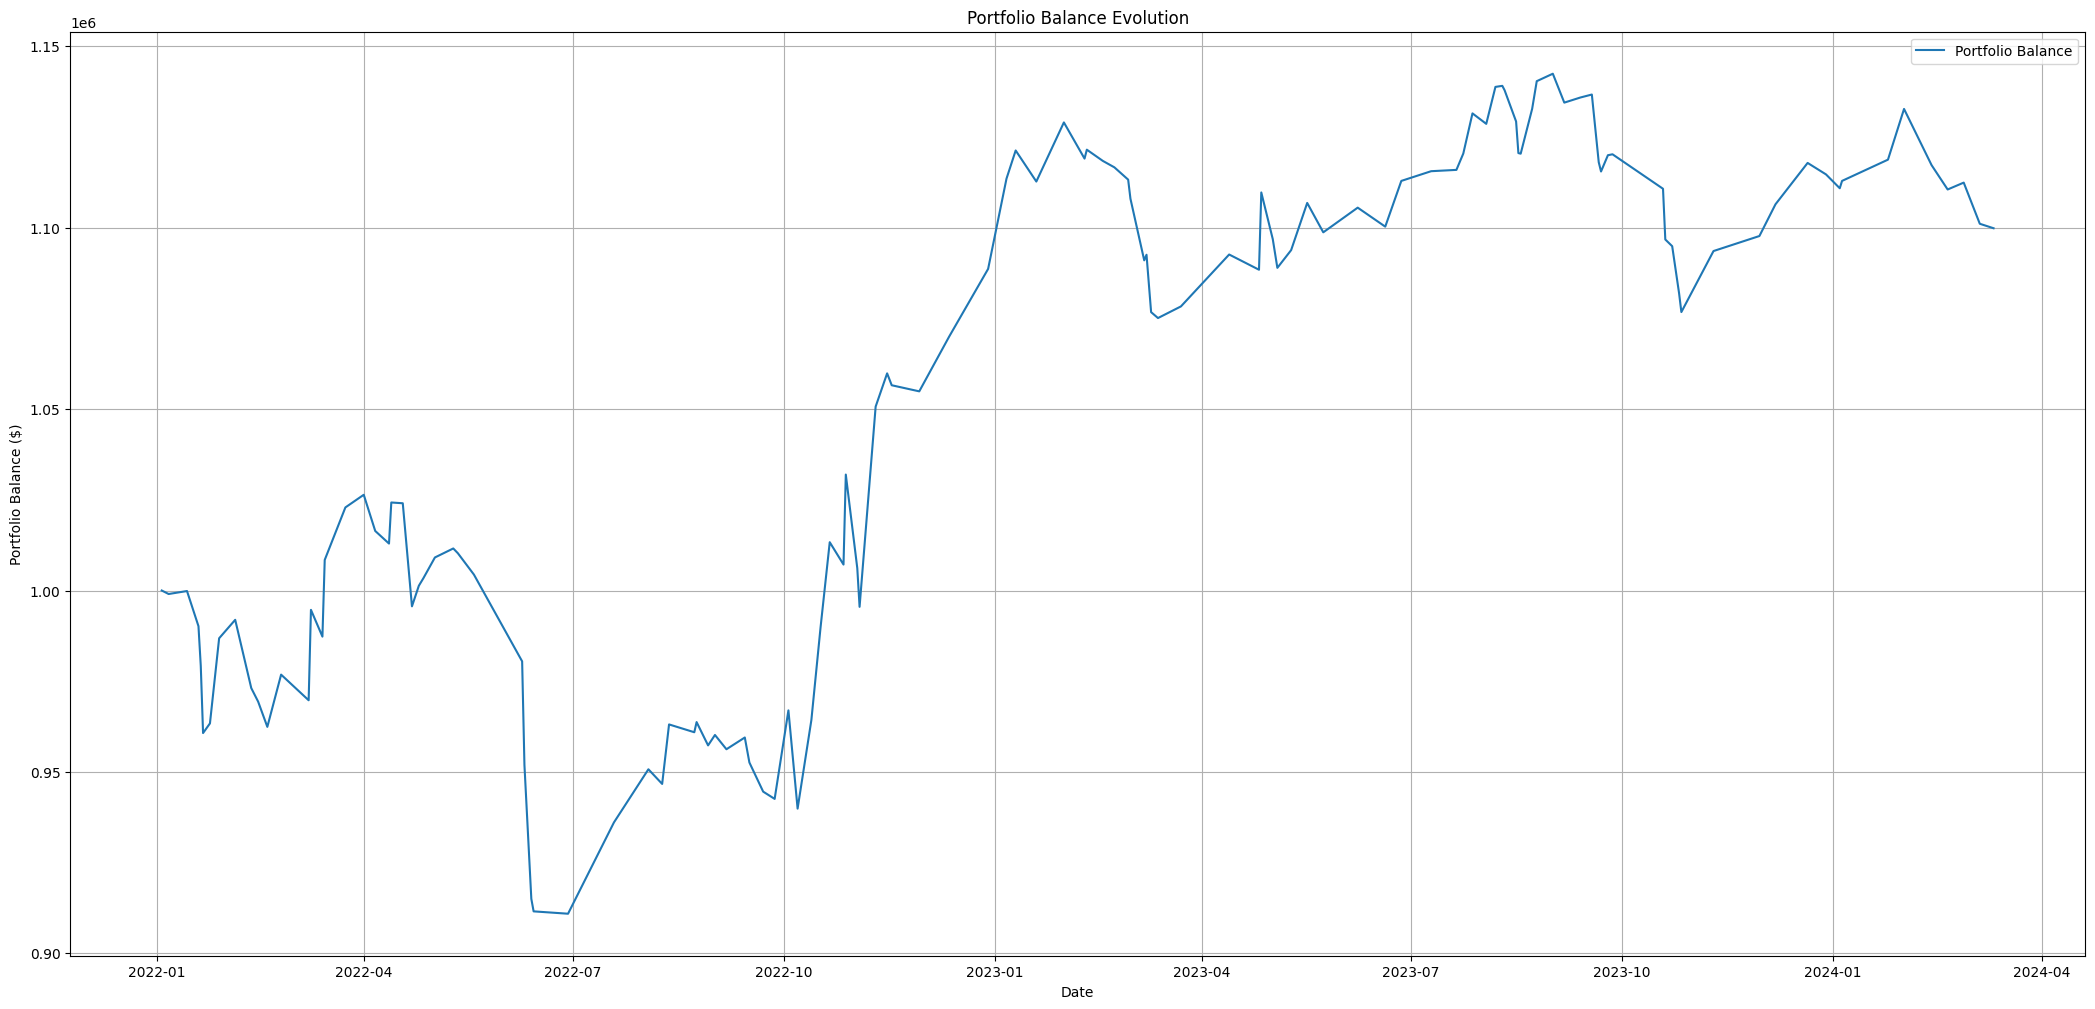

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine les trades gagnants et perdants en une seule DataFrame
all_trades = pd.concat([winning_trades, losing_trades])

# Trie les trades par date de prise de position
all_trades = all_trades.sort_index()

# Initialisez une variable pour représenter le solde de votre portefeuille
portfolio_balance = STARTING_BALANCE
portfolio_balances = [portfolio_balance]  # Liste pour stocker les soldes du portefeuille à chaque trade
dates = [START]  # Liste pour stocker les dates correspondant à chaque solde du portefeuille

# Parcourez chaque trade et mettez à jour le solde du portefeuille
for i, row in all_trades.iterrows():
    trade_return = (row['Sys_Ret'] - 1) * 100
    portfolio_balance *= 1 + (trade_return / 100)
    portfolio_balances.append(portfolio_balance)
    dates.append(i)

# Créez un graphique avec une courbe représentant l'évolution du solde du portefeuille
plt.figure(figsize=(26, 12))  # Définissez la taille du graphique
plt.plot(dates, portfolio_balances, label='Portfolio Balance')
plt.xlabel('Date')
plt.ylabel('Portfolio Balance ($)')
plt.title('Portfolio Balance Evolution')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Liste des symboles des indices à comparer et leurs noms complets
index_symbols = ['^GSPC', '^DJI', '^IXIC', '^FCHI', '^GDAXI']
index_names = ['S&P 500', 'Dow Jones', 'NASDAQ', 'CAC 40', 'DAX']

# Télécharger les données historiques pour chaque indice
index_data = yf.download(index_symbols, start=START, end=END)['Adj Close']

# Renommer les colonnes pour utiliser les noms complets des indices
index_data.columns = index_names

# Formater chaque cellule pour ajouter un espace entre les milliers et les centaines, et pour limiter à deux décimales
formatted_data = index_data.applymap(lambda x: f"{x:,.2f}")
formatted_data

[*********************100%%**********************]  5 of 5 completed


,S&P 500,Dow Jones,NASDAQ,CAC 40,DAX
Date,,,,,
2022-01-03,"36,585.06","7,217.22","16,020.73","4,796.56","15,832.80"
2022-01-04,"36,799.65","7,317.41","16,152.61","4,793.54","15,622.72"
2022-01-05,"36,407.11","7,376.37","16,271.75","4,700.58","15,100.17"
2022-01-06,"36,236.47","7,249.66","16,052.03","4,696.05","15,080.86"
2022-01-07,"36,231.66","7,219.48","15,947.74","4,677.03","14,935.90"
...,...,...,...,...,...
2024-03-12,"39,005.49","8,087.48","17,965.11","5,175.27","16,265.64"
2024-03-13,"39,043.32","8,137.58","17,961.38","5,165.31","16,177.77"
2024-03-14,"38,905.66","8,161.42","17,942.04","5,150.48","16,128.53"


[*********************100%%**********************]  5 of 5 completed


CAC 40 Total return: 13.12%
DAX Total return: 11.96%
S&P 500 Total return: 7.64%
Dow Jones Industrial Average Total return: 6.23%
NASDAQ Composite Total return: 2.08%
My portfolio return: 9.98%


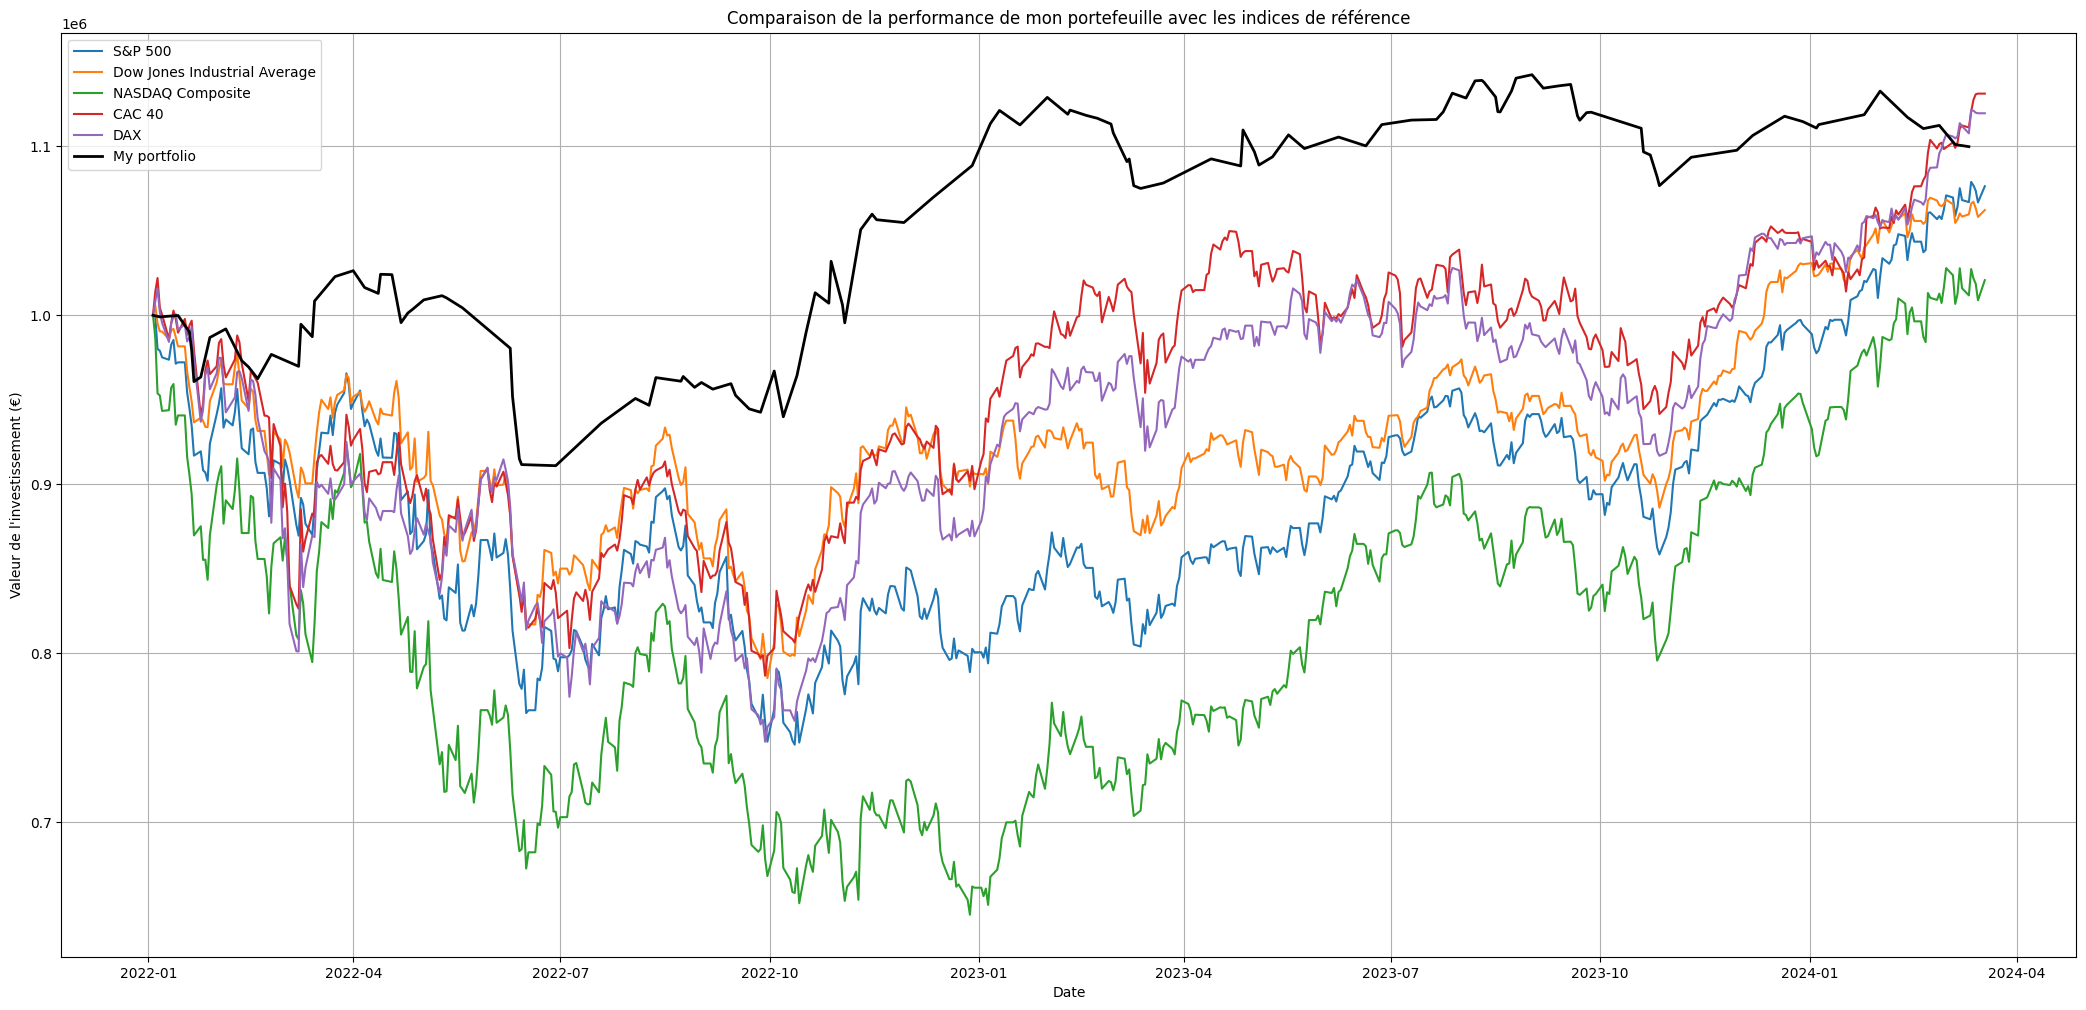

In [41]:
index_names = {
    '^GSPC': 'S&P 500',
    '^DJI': 'Dow Jones Industrial Average',
    '^IXIC': 'NASDAQ Composite',
    '^FCHI': 'CAC 40',
    '^GDAXI': 'DAX'
}

# Téléchargez les données
index_data = yf.download(index_symbols, start=START, end=END)['Adj Close'].ffill()

# Initialisation du montant investi
STARTING_BALANCE = 1000000
investment_amount = STARTING_BALANCE

# Calcul des valeurs des actifs
asset_values = {}
for symbol in index_symbols:
    first_value = index_data[symbol].iloc[0]
    shares_purchased = investment_amount / first_value
    asset_values[symbol] = index_data[symbol] * shares_purchased

# Conversion des valeurs des actifs en DataFrame pour un affichage simplifié
asset_values_df = pd.DataFrame(asset_values)

# Calcul des retours totaux pour chaque indice
total_returns = {}
for symbol in asset_values_df.columns:
    initial_value = asset_values_df[symbol].iloc[0]
    final_value = asset_values_df[symbol].iloc[-1]
    total_return = (final_value - initial_value) / initial_value * 100
    total_returns[symbol] = total_return

# Trier les retours totaux par ordre décroissant de grandeur
sorted_total_returns = sorted(total_returns.items(), key=lambda x: x[1], reverse=True)

# Afficher les retours totaux triés avec les noms complets
for symbol, return_value in sorted_total_returns:
    index_name = index_names.get(symbol, "Unknown Index")
    print(f'{index_name} Total return: {return_value:.2f}%')

print(f'My portfolio return: {sys_return}%')

# Graphique
plt.figure(figsize=(26, 12))
for symbol, values in asset_values.items():
    plt.plot(index_data.index, values, label=index_names[symbol])


# Affichage du portefeuille
plt.plot(dates, portfolio_balances, label='My portfolio', color='black', linewidth=2, linestyle='-')
plt.xlabel('Date')
plt.ylabel('Valeur de l\'investissement (€)')
plt.title('Comparaison de la performance de mon portefeuille avec les indices de référence')
plt.legend()
plt.grid(True)
plt.show()